In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from numpy import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<ipython-input-1-e91b8758e284>:11: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  from numpy import math


In [3]:
data = pd.read_csv('../data/online_retail_II.csv')
print(" Data imported successfully!!")
data.head(3).style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

 Data imported successfully!!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom


In [6]:
pd.set_option('display.max_columns', None)
def data_overview(df, head = 5):
    print("SHAPE OF DATASET".center(125, '-'))
    print("Row: ".format(df.shape[0]))
    print("Column: ".format(df.shape[1]))
    print("HEAD".center(125,'-'))
    print(df.head(head))
    print("DATA TYPES".center(125,'-'))
    print(df.dtypes.value_counts())
    print("MISSING VALUES".center(125,'-'))
    print(df.isnull().sum()[df.isnull().sum()> 0].sort_values(ascending = False))
    print("DUPLICATE VALUES".center(125,'-')) 
    print(df.duplicated().sum())
    print("STATISTICS OF DATA".center(125,'-'))
    print(df.describe(include="all"))
    print("DATA INFO".center(125,'-'))
    print(df.info())

data_overview(data)

-------------------------------------------------------SHAPE OF DATASET------------------------------------------------------
Row: 
Column: 
-------------------------------------------------------------HEAD------------------------------------------------------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009

#### Point to be noted
* The Dataset has Rows: 1067371 and Columns:8
* The Dataset has 3 types of columns: strings(5), integer(1), float(2)
* The Dataset has Missing values in Customer ID (243007) and Description (4382)
* Invoice starts with the 'c' needs to be cleaned as it is cancelled transaction
* The Dataset has duplicates
* Aslo check for negative value and outliers in Quantity and Price

**Data Wrangling**

#### Dealing with Missing values

In [11]:
#  Removing NaN's in Customer ID
print(data.shape)
data.dropna(subset="Customer ID", axis=0, inplace= True)
print(data.shape)


(1067371, 8)
(824364, 8)


In [13]:
data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

#### Removing cancelled products from invoice

In [14]:
#using one's compliment operator (~) we can unselect all the Invoice column which doesnt contain "C".
data = data[~data.Invoice.str.contains('C', na= False)
]

#### 3️⃣Removing Duplicates

In [17]:
# Removing duplicates (Values in all columns are identical)
print(data.duplicated().sum())
data = data.drop_duplicates(keep="first")
print(data.duplicated().sum())


26125
0


#### 4️⃣Checking for negative value

In [21]:
#4️Checking for negative value
print((data.Quantity< 0).sum())
print((data.Price< 0).sum())

0
0


#### 5️⃣Cleaning Outliers

In [22]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

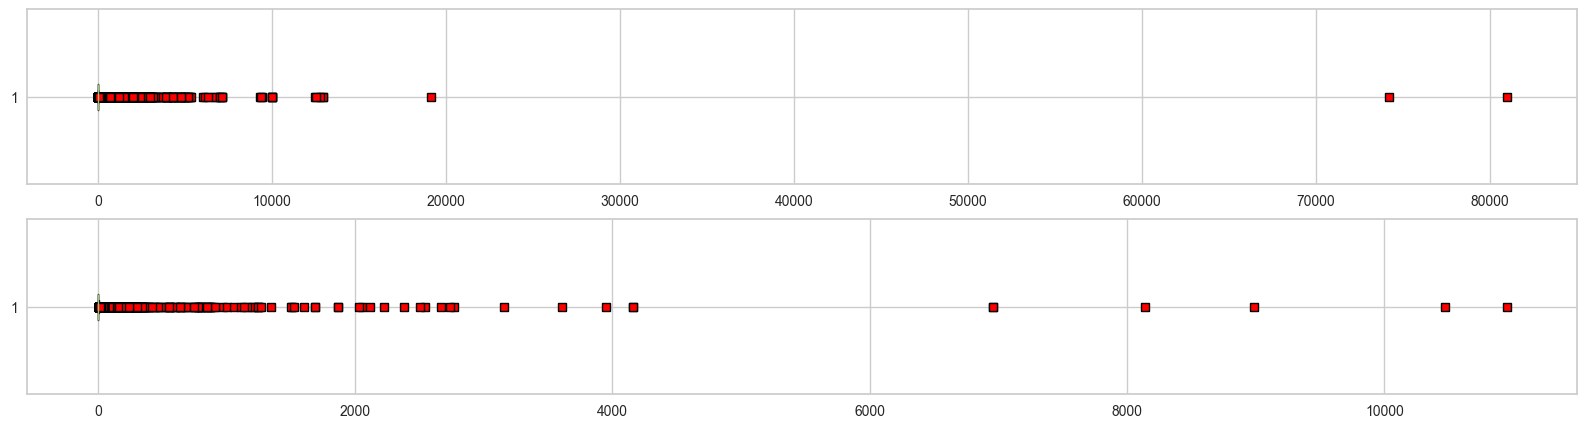

In [26]:
# Observing them before removing outliers.
fig, ax = plt.subplots(2,1, figsize =(20,5))
col_list = ["Quantity", "Price"]
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

In [27]:
replace_with_threshold(data, "Quantity")
replace_with_threshold(data, "Price")

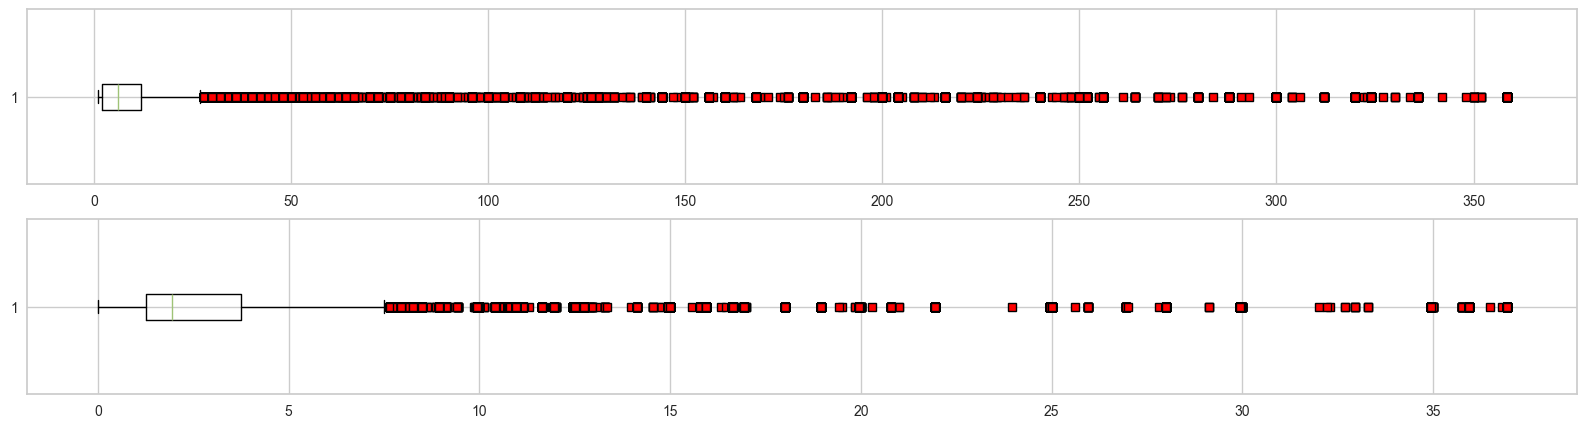

In [28]:
# Observing them after removing outliers.
fig, ax = plt.subplots(2,1, figsize =(20,5))
col_list = ["Quantity", "Price"]
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

## EDA : Feature Engineering

In [29]:
#Creating new feature Revenue
data['Revenue'] = data['Quantity'] * data['Price']

In [30]:
#Creating Features for RFM Model
#Changing data type to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [32]:
print(data['InvoiceDate'].max())
print(data['InvoiceDate'].min())

2011-12-09 12:50:00
2009-12-01 07:45:00


In [33]:
#RFM Featuring

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09.

Latest_Date = dt.datetime(2011,12,10)

#Creating RFM features with subset of customerID

RFM = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (Latest_Date - x.max()).days,
    'Invoice': lambda x: x.nunique(),
    'Revenue': lambda x: x.sum()
})

RFM['InvoiceDate'] = RFM['InvoiceDate'].astype(int)
#Renaming column names to Recency, Frequency and Monetary

RFM.rename(columns ={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'Monetary'
}, inplace = True)

RFM.reset_index().head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Customer ID,Recency,Frequency,Monetary
0,12346.000000,325,12,745.700000
1,12347.000000,2,8,4921.530000
2,12348.000000,75,5,1991.860000
3,12349.000000,18,4,3786.500000
4,12350.000000,310,1,331.340000


## Introducing New Feature : Interpurchase-Time

#### The Fourth varibale of RFM, InterPurchase Time, is a measure of average time gap between total shopping trips by a customer. The Interpurchase Time is calcluted as fallows :

* T = L/(F-1) = (Tn - T1)/(F-1)

* T --> Interpurchase Time
* L --> Shopping Cycle
 * F --> Frequency
 * T1 --> First purchase
 * Tn --> Last purchase
* Note: We consider only those customers who made purchase more than once.

In [35]:
RFM = RFM[RFM['Frequency']>1]
RFM.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,12,745.70
12347.0,2,8,4921.53
12348.0,75,5,1991.86
12349.0,18,4,3786.50
12352.0,36,10,2098.94


In [37]:
Shopping_Cycle = data.groupby('Customer ID').agg({
    'InvoiceDate' : lambda x: (x.max() - x.min()).days
})

In [38]:
RFM['Shopping_Cycle'] = Shopping_Cycle
RFM.head()

,Recency,Frequency,Monetary,Shopping_Cycle
Customer ID,,,,
12346.0,325,12,745.70,400
12347.0,2,8,4921.53,402
12348.0,75,5,1991.86,362
12349.0,18,4,3786.50,570
12352.0,36,10,2098.94,356


In [41]:
RFM['Interpurchase_Time'] = RFM['Shopping_Cycle'] // RFM['Frequency']
RFMT = RFM[['Recency', 'Frequency','Monetary','Interpurchase_Time']]
RFMT.head()

,Recency,Frequency,Monetary,Interpurchase_Time
Customer ID,,,,
12346.0,325,12,745.70,33
12347.0,2,8,4921.53,50
12348.0,75,5,1991.86,72
12349.0,18,4,3786.50,142
12352.0,36,10,2098.94,35
